In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from graphviz import Source
from sklearn import tree

RANDOM_STATE = 12

# import custom classes for pipeline
from prep import FeatureGemerator, FeatureSelector

In [2]:
# load_data 
df = pd.read_csv("BPL.csv")
df.sample(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
4779,4780,39,14,20,90747,1,0.6,3,0,0,0,0,1,0
1687,1688,63,39,83,90025,3,2.0,3,0,0,0,0,1,1
4437,4438,63,38,63,92507,2,1.5,1,0,0,0,0,1,0
2325,2326,55,30,85,94591,1,0.1,3,0,0,0,0,0,0
283,284,61,36,40,90029,3,0.5,2,0,0,1,0,1,0


In [3]:
# load grid_search results 
scoring_df = pd.read_csv('scoring_df.csv')
scoring_df

,model,accuracy,precision,recall,roc_auc,f1
0,CatBoostClassifier,0.983,0.954023,0.864583,0.930079,0.907104
1,RandomForestClassifier,0.980,0.952381,0.833333,0.914454,0.888889
2,DecisionTreeClassifier,0.980,0.941860,0.843750,0.919110,0.890110
3,GradientBoostingClassifier,0.980,0.941860,0.843750,0.919110,0.890110


In [4]:
# train test split
target_col = ['Personal Loan']

X, y = df.drop(target_col, axis=1), df[target_col]

metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'roc_auc': roc_auc_score, 
           'f1': f1_score}

In [5]:
# feature_engeneering_pipeline
feature_engeneering_pipeline = joblib.load('data_engeneering_pipeline.pkl')
feature_engeneering_pipeline.transform(X.head(1))

,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,IsMortgaged,IsFamily,IsEducated,IsMortgaged75,IsIncome75,IsCCAvg75
0,49,4,1.6,1,0,1,0,0,0,0,1,0,0,0,0


In [6]:
# load model (cb_classifier)
cb_classifier = joblib.load('models\\cb_model.pkl')
cb_classifier

In [7]:
# making predictions
print(cb_classifier.predict(feature_engeneering_pipeline.transform(X.head(1))))

# predict proba
print(cb_classifier.predict_proba(feature_engeneering_pipeline.transform(X.head(1))))

[0]
[[9.99966897e-01 3.31031296e-05]]


### Общий пайплайн
Для упрощения процесса получения предсказаний сделаем pipeline с преобразованием сырых данных и финальной моделью (CatBoostClassifier).

In [8]:
# concat_pipeline
model_pipeline = Pipeline([
        ('feature_engeneering_pipeline', feature_engeneering_pipeline),
        ('cb_classifier', cb_classifier)
    ])

In [9]:
# making predictions with pipeilne
print(model_pipeline.predict(X.head(1)))

# predict proba with pipeline
print(model_pipeline.predict_proba(X.head(1)))

[0]
[[9.99966897e-01 3.31031296e-05]]


### Интерпретация модели
С помощью градиентного бустинка (в данном случае, CatBoostClassifier), можно получить feature_importance для понимания важности признаков модели.

In [43]:
feature_importance_df = cb_classifier.get_feature_importance(prettified=True)
feature_importance_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Feature Id,Income,Education,Family,CCAvg,IsEducated,Mortgage,CD Account,IsCCAvg75,IsIncome75,Online
Importances,25.173,17.3299,17.021,16.327,6.98986,3.20094,3.19656,2.72506,2.47061,2.40087


Самыми влиятельными признаками являются Income, Education и Family. Это довольно логично с точки зрения банка: Наиболее важным для банка является показатель дохода, а также довольно сильными показателями является семья и образование.

### Валидация модели
Для оценки качества модели мы использовали стратифицированную k-Fold валидацию на всем датасете с разбиением на 5 фолдов.


In [10]:
%%time 

# stratified StratifiedKFold
cv = StratifiedKFold(n_splits=11, shuffle=True, random_state=RANDOM_STATE)

# scores
scoring = list(scoring_df.columns)[1:]
# print(f'Scoring columns: {scoring}')

scores = cross_validate(model_pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
scores.keys()

Wall time: 2min 33s


dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_roc_auc', 'test_f1'])

In [11]:
# cv_scores to dateframe
model_cv_scores = pd.DataFrame()
model_cv_scores['fold'] = np.arange(1, 12)

for score in scores:
    if 'test_' in score:
        model_cv_scores[score] = scores[score]
        
model_cv_scores

,fold,test_accuracy,test_precision,test_recall,test_roc_auc,test_f1
0,1,0.989011,1.000000,0.886364,0.997678,0.939759
1,2,0.989011,1.000000,0.886364,0.993917,0.939759
2,3,0.986813,0.952381,0.909091,0.997788,0.930233
3,4,0.984615,0.974359,0.863636,0.998507,0.915663
4,5,0.984615,0.930233,0.909091,0.997678,0.919540
5,6,0.993407,1.000000,0.931818,0.998949,0.964706
6,7,0.984581,0.950000,0.883721,0.998246,0.915663
7,8,0.995595,0.955556,1.000000,0.999830,0.977273
8,9,0.986784,1.000000,0.860465,0.997397,0.925000
9,10,0.991189,1.000000,0.906977,0.999378,0.951220


### Стабильность модели по фолдам

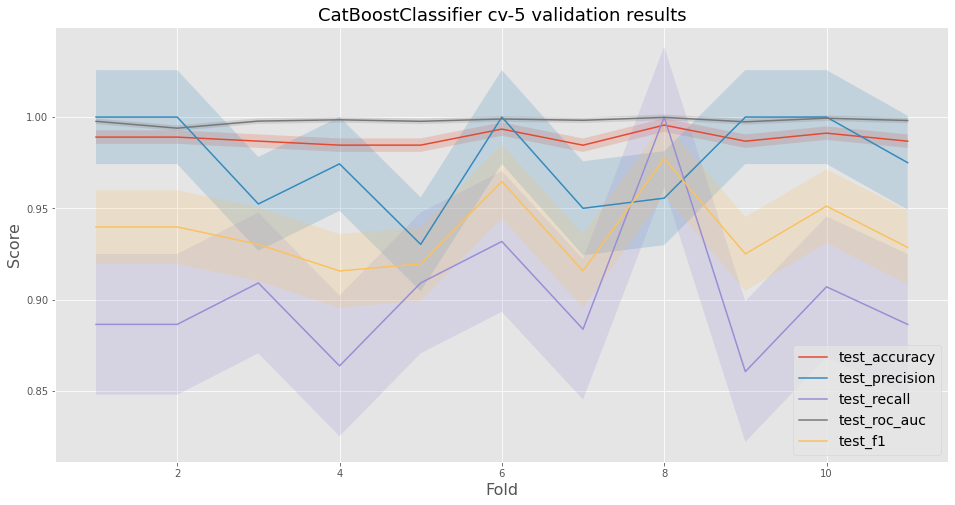

In [12]:
# vizualization
std_coef = 1.

plt.figure(figsize=(16, 8))

for column in model_cv_scores:
    if column != 'fold':
        plt.plot(model_cv_scores['fold'], model_cv_scores[column], label=column)
        plt.fill_between(x=model_cv_scores['fold'], 
                         y1=model_cv_scores[column]+std_coef*model_cv_scores[column].std(),
                         y2=model_cv_scores[column]-std_coef*model_cv_scores[column].std(),
                         alpha=.2)
        
        
plt.title('CatBoostClassifier cv-5 validation results', size=18)
plt.xlabel('Fold', size=16)
plt.ylabel('Score', size=16)

plt.legend(loc='lower right', fontsize=14);

In [75]:
model_cv_scores.loc[:, 'test_accuracy':].std()

test_accuracy     0.003692
test_precision    0.025749
test_recall       0.038578
test_roc_auc      0.001541
test_f1           0.020207
dtype: float64

Модель имеет довольно большой разброс в качестве предсказания по фолдам: стандатное отклонение по f1_score - 0.02 или 2%

Что нам это дает?..

Оценим качество предсказаний модели при сильном смещении распределения классов. Для этого возьмем два крайних варианта - предсказание всех объектов с целевой переменной 0 и всех объектов с целевой переменной 1.

In [71]:
X_only_true = X[(y == 1).values]
X_only_false = X[(y == 0).values]

preds_only_true = model_pipeline.predict(X_only_true)
preds_only_false = model_pipeline.predict(X_only_false)

1 - preds_only_false.mean(), preds_only_true.mean()

(0.9988938053097345, 0.9604166666666667)

Модели градиентного бустинга являются довольно устойчивыми к изменению распределения целевой переменной, поэтому наша модель показала высокую точность на предсказании по датасету с единственным классом